# 用fastGB生成天琴双白矮星信号的实例教程

In [20]:
import numpy as np
import sys, os
import time

import matplotlib.pyplot as plt
#import matplotlib as mpl
#import pandas as pd
from scipy.fftpack import fft,rfft

In [21]:
#from LISAhdf5 import LISAhdf5,ParsUnits
#import tdi
#import FastGB as FB    # 导入fastGB
from gwspace import Constants as const

from gwspace import FastGB as FB
from gwspace.Constants import YRSID_SI

# fastGB

In [22]:
def GenerateFastGB(p, Tobs, Cadence, oversample, TD = False):   # 默认TD = False，即生成频域信号。如果要生成时域信号那么需要标明TD = True
    #{{{
    ### unfolding the parameters and producing the list of Params
    Amp = p[0]
    f0 = p[1]
    fdot = p[2]
    iota = p[3]
    psi = p[4]
    phi0 = p[5]
    EclLat = p[6]
    EclLon = p[7]

    Tobs = Tobs
    del_t = Cadence
    Ns = len(Amp)    # 源的个数

    prm = []
    for i in range(Ns):
        tmp = np.array([f0[i], fdot[i], EclLat[i], EclLon[i], Amp[i], iota[i], psi[i], phi0[i]])
        prm.append(tmp)
    fastB = FB.FastGB("Test", dt=del_t, Tobs=Tobs, orbit="analytic", detector="TianQin")

    if TD:
        Xt, Yt, Zt = fastB.TDI(T=Tobs,dt=del_t,simulator='synthlisa',table=prm,
        algorithm='Michele',oversample=oversample)
        tm = np.arange(len(Xt))*del_t

        return (tm, Xt, Yt, Zt)

    else:
        Xf, Yf, Zf = fastB.fourier(T=Tobs,dt=del_t,simulator='synthlisa',
        table=prm,algorithm='Michele',oversample=oversample)
        return(Xf.f,Xf[:],Yf[:],Zf[:])


In [23]:
f0=[0.00622028]
fd=[7.48528554e-16]
beta=[np.pi/2+0.082205]  #ecliptic latitude [rad]
Lambda=[2.10225]  #ecliptic longitude [rad]
Amp=[6.37823e-23]
iota=[0.645772]
psi=[2.91617795]
phi0=[3.1716561]

# 两年观测时长，15s采一个点。
# 在fastGB程序中，Tobs=62914560和dt=15是默认值。
# 这个15s的采样间隔是适用于LISA的，但实际操作中并不影响，因为它只是一个缺少输入条件时的默认值而已，你可以在这里输入任何你需要的Cadence值。
# 在这里，仅作为一个初步的例子，我们用了15s的采样间隔。实际天琴的采样间隔可能是1s左右，你可以自行修改成更符合实情的Tobs和Cadence。
Tobs = YRSID_SI
Cadence = 15.0

paras = [Amp, f0, fd, iota, psi, phi0, beta, Lambda]

# 调用函数生成频域信号（如果需要时域，则在括号里再加一个TD = True即可）
J0806_FD_highos = GenerateFastGB(paras, Tobs, Cadence, 32768)

# 处理得到的数据，方便画图
J0806_FD_highos = np.array(J0806_FD_highos).T
J0806_FD_highos[:,1:] = J0806_FD_highos[:,1:]*2

import pandas as pd
df_J0806_highos = pd.DataFrame(np.abs(J0806_FD_highos),columns=['f','TDI X (FD)', 'TDI Y (FD)', 'TDI Z (FD)'])


1 finished, 2 s elapsed (0/s)


# 卢杨编写的解析波形

In [24]:
from numpy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import integrate
from scipy.fftpack import fft,rfft

def sinc(parameter):
    sinc = np.sin(parameter)/parameter
    return sinc

def h_X(t,f,beta,Lambda,f_drift, Amp, iota, psi, phi0):

    beta = beta      # 黄纬
    Lambda =Lambda   # 黄经
    f_drift =f_drift
    t=t
    T = max(t)

    # 以下计算q向量要用到：
    Lc = 0.5777499579392          # L/c 自然单位制
    e=0.0167       #地球轨道的偏心率
    yearspersecond = 3.1709791983764586e-8
    alpha = 2*np.pi*t*yearspersecond + (2.102137+np.pi-np.pi/4.0)
    period = 3.65*24*60*60
    isc = 1.652897
    bsc = 2.102137
    kapa = 20/180 * np.pi
    beta_1 = 2.0*np.pi*(1-1)/3.0 + kapa;
    beta_2 = 2.0*np.pi*(2-1)/3.0 + kapa;
    beta_3 = 2.0*np.pi*(3-1)/3.0 + kapa;
    gamma_1 = 2.0*np.pi*(t/period) + beta_1
    gamma_2 = 2.0*np.pi*(t/period) + beta_2
    gamma_3 = 2.0*np.pi*(t/period) + beta_3
    
    
    # 以下计算相位phi_t要用到：
    eta_0 =(2.102137+np.pi-np.pi/4.0)     # η0 是t=0时航天器在环太阳轨道上的位置
    omega = 2*np.pi*f                     # 角频率 2Πf
    omegaDerivative = 2*np.pi*f_drift     # omega_dot
    yearspersecond = 3.1709791983764586e-8
    OMRGA = 2*np.pi*yearspersecond
    R = 499.004                           # 1AU = 1.5e11 m /c
    
    # 计算探测器通道响应要用到：
    x = Lc * omega
    
    
    ######################### 航天器相对于guiding-center的位置向量q，忽略偏心率项 ####################################
    
    # x坐标，指标中的前一个数字123分别表示3个航天器
    q_vectors_11 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_1) - np.sin(bsc)*np.sin(gamma_1))
    q_vectors_21 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_2) - np.sin(bsc)*np.sin(gamma_2))
    q_vectors_31 = 1.0/2*(np.cos(2*(alpha))-3.0)*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.cos(bsc)*np.cos(gamma_3) - np.sin(bsc)*np.sin(gamma_3))
    
    # y坐标
    q_vectors_12 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_1) + np.cos(bsc)*np.sin(gamma_1))
    q_vectors_22 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_2) + np.cos(bsc)*np.sin(gamma_2))
    q_vectors_32 = 1.0/2*(np.sin(2*(alpha)))*e*499.004/Lc + 1/3**0.5*(np.cos(isc)*np.sin(bsc)*np.cos(gamma_3) + np.cos(bsc)*np.sin(gamma_3))
      
    # z坐标
    q_vectors_13 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_1)
    q_vectors_23 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_2)
    q_vectors_33 = -1.0/3**0.5*np.sin(isc)*np.cos(gamma_3)
    
    ######################################### 臂长向量n ########################################

    # 向量n1 = q2-q3，三维，臂长1对应的向量
    n_vectors_11 = q_vectors_21 - q_vectors_31
    n_vectors_12 = q_vectors_22 - q_vectors_32
    n_vectors_13 = q_vectors_23 - q_vectors_33
    
    # 向量n2 = q3-q1
    n_vectors_21 = q_vectors_31 - q_vectors_11
    n_vectors_22 = q_vectors_32 - q_vectors_12
    n_vectors_23 = q_vectors_33 - q_vectors_13
    
    # 向量n3 = q1-q2
    n_vectors_31 = q_vectors_11 - q_vectors_21
    n_vectors_32 = q_vectors_12 - q_vectors_22
    n_vectors_33 = q_vectors_13 - q_vectors_23

    
    ##############################    相位函数，包含多普勒调制   ##############################

    phi_t = omega*t + 0.5*omegaDerivative*t**2 + phi0 +(omega + omegaDerivative*t)*R * np.cos(beta) * np.cos(OMRGA*t + eta_0 - Lambda)


    ################# polarization basis in the solar system barycenter frame ##################
    u_vectors_1 = np.sin(beta)*np.cos(Lambda)  # dk/dβ
    u_vectors_2 = np.sin(Lambda)*np.sin(beta)
    u_vectors_3 = -np.cos(beta)

    v_vectors_1 = np.sin(Lambda)
    v_vectors_2 = -np.cos(Lambda)
    v_vectors_3 = 0.0

    
	################# direction of the wave propagation. 波矢 ########################
    k_vectors_1 = -np.cos(Lambda)*np.cos(beta)
    k_vectors_2 = -np.cos(beta)*np.sin(Lambda)
    k_vectors_3 = -np.sin(beta)


    # u标量
    u_scalar_1 = -0.5*((n_vectors_11*u_vectors_1 + n_vectors_12*u_vectors_2 +n_vectors_13*u_vectors_3)**2-\
                            (n_vectors_11*v_vectors_1 + n_vectors_12*v_vectors_2 +n_vectors_13*v_vectors_3)**2)

    u_scalar_2 = -0.5*((n_vectors_21*u_vectors_1 + n_vectors_22*u_vectors_2 +n_vectors_23*u_vectors_3)**2-\
                            (n_vectors_21*v_vectors_1 + n_vectors_22*v_vectors_2 +n_vectors_23*v_vectors_3)**2)

    u_scalar_3 = -0.5*((n_vectors_31*u_vectors_1 + n_vectors_32*u_vectors_2 +n_vectors_33*u_vectors_3)**2-\
                            (n_vectors_31*v_vectors_1 + n_vectors_32*v_vectors_2 +n_vectors_33*v_vectors_3)**2)

    # v标量
    v_scalar_1 = ((n_vectors_11*u_vectors_1 + n_vectors_12*u_vectors_2 +n_vectors_13*u_vectors_3)*\
                       (n_vectors_11*v_vectors_1 + n_vectors_12*v_vectors_2 +n_vectors_13*v_vectors_3))

    v_scalar_2 = ((n_vectors_21*u_vectors_1 + n_vectors_22*u_vectors_2 +n_vectors_23*u_vectors_3)*\
                       (n_vectors_21*v_vectors_1 + n_vectors_22*v_vectors_2 +n_vectors_23*v_vectors_3))

    v_scalar_3 = ((n_vectors_31*u_vectors_1 + n_vectors_32*u_vectors_2 +n_vectors_33*u_vectors_3)*\
                       (n_vectors_31*v_vectors_1 + n_vectors_32*v_vectors_2 +n_vectors_33*v_vectors_3))
    
    
    ####################################### 探测器X通道响应 #######################################################
    
    X_1 = u_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -u_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_2 = v_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -v_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.cos(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_3 = u_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -u_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    X_4 = v_scalar_2*(sinc((1 + k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23)*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -3*x/2.0)\
                          + sinc((1 - (k_vectors_1*n_vectors_21 + k_vectors_2*n_vectors_22 + k_vectors_3*n_vectors_23))*x/2.0)\
                          *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_21 + k_vectors_2*q_vectors_22 + k_vectors_3*q_vectors_23) -5*x/2.0))\
            -v_scalar_3*(sinc((1 + k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33)*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -5*x/2.0)\
                         + sinc((1 - (k_vectors_1*n_vectors_31 + k_vectors_2*n_vectors_32 + k_vectors_3*n_vectors_33))*x/2.0)\
                         *np.sin(phi_t + x/2.0*(k_vectors_1*q_vectors_31 + k_vectors_2*q_vectors_32 + k_vectors_3*q_vectors_33) -3*x/2.0))


    # 响应后的信号（只包含内秉参数）
    h1 =2*omega*Lc*np.sin(omega*Lc)*X_1
    h2 =2*omega*Lc*np.sin(omega*Lc)*X_2
    h3 =2*omega*Lc*np.sin(omega*Lc)*X_3
    h4 =2*omega*Lc*np.sin(omega*Lc)*X_4
    h=[h1,h2,h3,h4]
    
    # 外秉部分
    h_zero =Amp
    h_plus = h_zero*(1 + (np.cos(iota))**2)
    h_cross = 2*h_zero*np.cos(iota)
    
    a_1 = h_plus * np.cos(phi0) * np.cos(2*psi) - h_cross*np.sin(phi0)*np.sin(2*psi)
    a_2 = h_plus * np.cos(phi0) * np.sin(2*psi) + h_cross*np.sin(phi0)*np.cos(2*psi)
    a_3 = -h_plus * np.sin(phi0) * np.cos(2*psi) - h_cross*np.cos(phi0)*np.sin(2*psi)
    a_4 = -h_plus * np.sin(phi0) * np.sin(2*psi) + h_cross*np.cos(phi0)*np.cos(2*psi)
    
    TDIX_t=h1*a_1+h2*a_2+h3*a_3+h4*a_4
    
    return TDIX_t



In [25]:
f0=[0.00622028]
fd=[7.48528554e-16]
beta=[-0.082205]  #ecliptic latitude [rad]
Lambda=[2.10225]  #ecliptic longitude [rad]
Amp=[6.37823e-23]
iota=[0.645772]
psi=[2.91617795]
phi0=[3.1716561]

# 两年观测时长，15s采一个点。
# 在fastGB程序中，Tobs=62914560和dt=15是默认值。
# 这个15s的采样间隔是适用于LISA的，但实际操作中并不影响，因为它只是一个缺少输入条件时的默认值而已，你可以在这里输入任何你需要的Cadence值。
# 在这里，仅作为一个初步的例子，我们用了15s的采样间隔。实际天琴的采样间隔可能是1s左右，你可以自行修改成更符合实情的Tobs和Cadence。
Tobs = 62914560.0
Cadence = 15.0


t=np.arange(0, Tobs, 15)  # 同样取2年观测时长，15s采样间隔

Nsignal = len(f0)   # 信号数量

X = np.zeros((Nsignal,len(t)))
X_t_total = np.zeros(len(t))
for i in range(Nsignal):
    X[i,:]=h_X(t,f0[i],beta[i],Lambda[i],fd[i], Amp[i], iota[i], psi[i], phi0[i])
    X_t_total=X_t_total+X[i,:]

# fft
fs = 1/15
X_f = np.abs(np.fft.rfft(X_t_total))/len(X_t_total)*2
xf = np.linspace(0,fs/2,len(X_f))

# GCBwaveform

In [26]:
# %load gen_response_data.py
#!/usr/bin/env python
# ==================================
# File Name: gen_response_data.py
# Author: En-Kun Li, Han Wang
# Mail: lienk@mail.sysu.edu.cn, wanghan657@mail2.sysu.edu.cn
# Created Time: 2023-08-31 09:40:34
# ==================================

import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_y_slr_td, trans_y_slr_fd, get_XYZ_td, get_XYZ_fd, get_AET_fd, tdi_XYZ2AET
from gwspace.Orbit import detectors
from gwspace.Constants import DAY, YRSID_SI, MONTH
from gwspace.Noise import TianQinNoise, LISANoise, TaijiNoise


def generate_td_data(pars, s_type='gcb', det='TQ', show_y_slr=False):
    print("This is TD response generation code")
    Tobs = YRSID_SI
    delta_T = 15

    # tf = np.arange(0,Tobs, delta_T)
    # be careful, the arange method will lose the largest value
    tf = np.linspace(0, Tobs, int(Tobs/delta_T))

    print(f"Testing of {s_type} waveform")
    wf = waveforms[s_type](**pars)
    st = time.time()
    y_slr = get_y_slr_td(wf, tf, det)
    ed = time.time()
    print(f"Time cost is {ed-st} s for {tf.shape[0]} points")

    if show_y_slr:
        tags = [(1, 2), (2, 1), (2, 3), (3, 2), (3, 1), (1, 3)]
        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, y_slr[tag][f"{j}L"])
                plt.title(f"y_{tag} [{j}]L")

    st = time.time()
    X, Y, Z = get_XYZ_td(y_slr)
    A, E, T = tdi_XYZ2AET(X, Y, Z)
    ed = time.time()
    print("Time cost for cal XYZ and AET with y_slr is ", ed-st)
    # np.save(det+s_type+"_X_td.npy", np.array([tf, X]))
    return X,Y,Z,A,E,T



In [32]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": 2.10225,
    "Beta": -0.082205,
    "T_obs": YRSID_SI,
}

In [33]:
XTD,YTD,ZTD,ATD,ETD,TTD = generate_td_data(GCBpars)

This is TD response generation code
Testing of gcb waveform
Time cost is 2.908820867538452 s for 2103876 points
Time cost for cal XYZ and AET with y_slr is  0.059511661529541016


In [34]:
fs = 1/15
XFD = np.abs(np.fft.rfft(XTD))/len(XTD)*2
xf = np.linspace(0,fs/2,len(XFD))

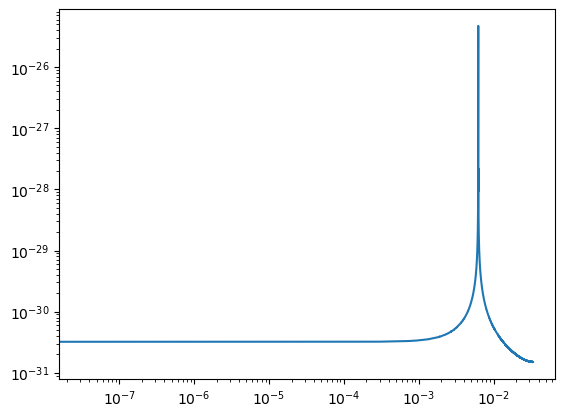

In [35]:
plt.plot(xf, XFD)
plt.xscale("log")
plt.yscale("log")

#plt.xlim(3e-4, 6e-4)

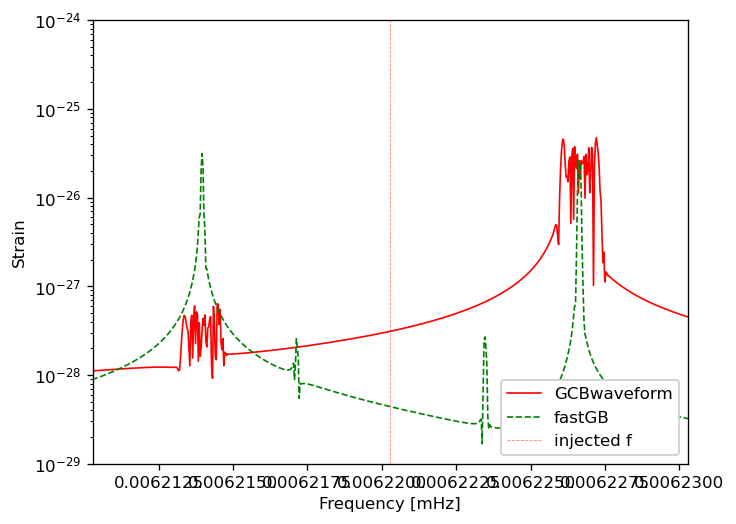

In [36]:
plt.figure(dpi=120)

plt.plot(xf, XFD, linewidth=1, color="r", label='GCBwaveform')
#plt.plot(xf, X_f.real, linewidth=1,color= 'orange', label='analytic waveform by LuYang')
plt.plot(J0806_FD_highos[:,0] , abs(J0806_FD_highos[:,1]), linestyle='--', linewidth=1,color= 'g', label='fastGB')


plt.axvline(f0[0], color='r' ,linestyle='--', linewidth=0.5 , alpha = 0.5 ,label='injected f')

plt.xlabel("Frequency [mHz]")
plt.ylabel("Strain")

plt.xlim(f0[0]-1e-5, f0[0]+1e-5)

# plt.xlim(9.928e-4, 9.948e-4)    # 左半边
# plt.xlim(10.055e-4, 10.075e-4)  # 右半边
plt.ylim(1e-29,1e-24)

plt.yscale("log")

plt.legend(loc=4, framealpha=1)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

ax.plot(xf*1e3, XFD, linewidth=1, label='GCB')
ax.plot(xf*1e3, X_f, linewidth=1,color= 'orange', label='Analytic')
ax.plot(J0806_FD_highos[:,0]*1e3 , np.abs(J0806_FD_highos[:,1]), linestyle='--', linewidth=1,color= 'g', label='FastGB')

ax.axvline(f0[0]*1e3 ,color='r' ,linestyle='--', linewidth=0.5 , alpha = 0.5 ,label='injected f')

ax.set_ylim(1e-33,1.5e-29)
ax.set_xlim(f0[0]*1e3-0.9e-2, f0[0]*1e3+0.925e-2)
#ax.set_xscale('log')
ax.set_yscale('log')

axins = ax.inset_axes((0.25, 0.65, 0.3, 0.3))
axins.plot(xf*1e3, XFD, linewidth=1, label='GCBwaveform')
axins.plot(xf*1e3, X_f, linewidth=1,color= 'orange', label='analytic waveform by LuYang')
axins.plot(J0806_FD_highos[:,0]*1e3 , np.abs(J0806_FD_highos[:,1]), linestyle='--', linewidth=1,color= 'g', label='fastGB')
axins.set_ylim(3e-32,1.5e-29)
axins.set_xlim(0.9933,0.994)
#ax.set_xscale('log')
axins.set_yscale('log')

#axins = ax.inset_axes((0.1, 0.5, 0.1, 0.1))
ax.set_xlabel("Frequency [mHz]")
ax.set_ylabel("Strain")

plt.legend(loc=4)

##plt.savefig("../../../TQ-SDS/figs/GCB_fd.pdf", dpi=360)